##  Monte Carlo Methods for Option Pricing

#### Introduction 

In this notebook, I explore and implement various Monte Carlo methods for option pricing. My goal is to understand and evaluate the strengths and limitations of these stochastic techniques by applying them to practical examples and analyzing the results.

Monte Carlo simulations are widely used in computational finance due to their flexibility in modeling uncertainty and their applicability to high-dimensional problems. However, validating the accuracy of these methods can be non-trivial. Throughout this project, I highlight the nuances of convergence, sample size sensitivity, and the impact of discretization on performance.

Challenges:
Before diving into code, it's important to acknowledge some of the common pitfalls and challenges faced when validating Monte Carlo methods:
 - Small sample size – Early experiments might give misleading results due to high variance.
 - Inaccurate discretization – Using low-accuracy schemes can undermine the validity of simulations.
 - Bugs in implementation – Debugging numerical code is non-trivial, and silent errors can appear like convergence failures.
 - Misinterpreting convergence – Sometimes, a method might already be performing optimally, but error plots suggest otherwise due to saturation.
 - These challenges reflect real-world obstacles, and in this notebook, I will walk through how I encountered and addressed some of them during my experimentation.

### Simulating European Call Options with Monte Carlo – Euler-Maruyama Method

I begin by simulating the underlying asset's dynamics using the Euler-Maruyama discretization of the Black-Scholes stochastic differential equation (SDE).


#### Black-Scholes Model

The asset price $S(t)$ under the risk-neutral measure follows the SDE:

$$
dS(t) = rS(t)\,dt + \sigma S(t)\,dB(t), \quad S(0) = S_0 > 0
$$

where:

- $r$: risk-free interest rate  
- $\sigma$: volatility  
- $B(t)$: standard Brownian motion

The price of a **European call option** with strike $K$ and maturity $T$ is given by:

$$
C_0 = \mathbb{E}^{\mathbb{Q}} \left[ e^{-rT}(S(T) - K)_+ \right]
$$

While this can be computed in closed form using the Black-Scholes formula, I wanted to simulate it using Monte Carlo methods to better understand the numerical approach and the role of randomness in pricing.

---


#### Task 1: Euler-Maruyama Scheme




To numerically simulate $S(t)$, I used the **Euler-Maruyama method** to discretize the Black-Scholes SDE.

We divide the time interval $[0, T]$ into $m$ steps of equal size $\tau = \frac{T}{m}$. The discretization scheme is then:

$$
\hat{S}_{t_{j+1}} = \hat{S}_{t_j} + r\hat{S}_{t_j}\tau + \sigma \hat{S}_{t_j} \sqrt{\tau} \Delta_j, \quad j = 0, 1, \ldots, m-1
$$

where $\Delta_j \sim \mathcal{N}(0, 1)$ are i.i.d. standard normal random variables.

This method provides a first-order approximation of the continuous-time stochastic process and is commonly used for simulating asset prices in financial applications.

In [1]:
import numpy as np

def euler_maruyama(S0, tau, m, r, sigma, n):
    """
    Simulates the Black-Scholes SDE using the Euler-Maruyama method.

    Parameters:
    - S0: Initial stock price
    - tau: Time step size
    - m: Number of time steps
    - r: Risk-free interest rate
    - sigma: Volatility
    - n: Number of Monte Carlo simulations

    Returns:
    - ST: Simulated stock prices at maturity (T)
    """
    S = np.full((n,), S0)  # Initialize all stock prices at S0

    for _ in range(m):
        Z = np.random.normal(0, 1, n)  # Generate n standard normal samples
        S = S + r * S * tau + sigma * S * np.sqrt(tau) * Z  # Euler-Maruyama update

    return S  # Return simulated asset prices at T

In [2]:
# Example parameters
S0 = 100       # Initial price
T = 1          # Time horizon (1 year)
m = 252        # Daily steps in a year
tau = T / m
r = 0.05       # Risk-free rate
sigma = 0.2    # Volatility
n = 10000      # Simulations

# Simulate
simulated_prices = euler_maruyama(S0, tau, m, r, sigma, n)

# Display some sample prices
print("Sample simulated prices at T:", simulated_prices[:10])

Sample simulated prices at T: [ 68.2313566  118.25412703  92.15429205  88.1282523  105.50072734
 115.27524366 161.57178264  88.77076804 120.93109278 101.10073793]


Ensuring that the implementation was vectorized was essential for computational efficiency, particularly given the scale of the simulations (e.g., 10,000 or more sample paths). In subsequent sections, I utilise the simulated terminal asset prices to estimate the value of the European call option and to examine the convergence properties of the Monte Carlo method.

#### Task 2: Convergence Analysis for European Call Option Pricing




In this section, I investigate the **weak convergence** of the Euler-Maruyama scheme applied to the Black-Scholes SDE for pricing a European call option. Specifically, I test whether the following first-order weak error estimate holds:

$$
\left| \mathbb{E} \left[ e^{-rT} (\hat{S}(T) - K)^+ \right] - C_0 \right| \lesssim D\tau
$$

where $C_0$ is the exact Black-Scholes price, and $\tau = T/m$ is the time step size for $m$ steps over $[0, T]$.

---

##### Setup

We define the following parameters:

- $S_0 = 65$ (initial asset price)  
- $K = 100$ (strike price)  
- $r = 0.05$ (risk-free rate)  
- $\sigma = \sqrt{0.04} = 0.2$ (volatility)  
- $T = 1$ (maturity in years)  
- $n = 4 \times 10^6$ (number of Monte Carlo simulations)

The exact option value $C_0$ is computed using the Black-Scholes formula:

$$
C_0 = S_0 \Phi(d_1) - Ke^{-rT} \Phi(d_2)
$$

with:

$$
d_1 = \frac{\ln(S_0/K) + (r + \frac{1}{2} \sigma^2)T}{\sigma \sqrt{T}}, \quad
d_2 = d_1 - \sigma \sqrt{T}
$$

Here, $\Phi(\cdot)$ denotes the cumulative distribution function of the standard normal distribution.

---

##### Monte Carlo Estimator

The Monte Carlo estimator for each $m$ is defined as:

$$
\alpha_{n,m} = \frac{1}{n} \sum_{i=1}^n e^{-rT} \left( \hat{S}^{(i)}(T) - K \right)^+
$$

We then compute the absolute bias:

$$
\text{Bias} = |\alpha_{n,m} - C_0|
$$

for a range of time step counts $m \in \{2, 4, 8, 16, 32, 64, 128\}$.

---

##### Code outline
In the following code block, I compare the numerical Monte Carlo estimates of a European call option price (using the Euler-Maruyama method) with the exact Black-Scholes value to analyze how the bias decreases as the number of time steps $m$ increases.

- I first define the Black-Scholes formula (black_scholes_call) to compute the exact option price $C_0$, which acts as my benchmark.

- Then I define a Monte Carlo estimator (monte_carlo_estimator) that uses my euler_maruyama simulation to generate terminal stock prices $\hat{S}(T)$, from which it calculates the discounted payoff $\max(\hat{S}(T) - K, 0)$.

- I loop through various values of $m$ (time steps) and compute:

    - The bias between the Monte Carlo estimate and the true price.

    - The standard deviation of the estimator to assess variance.

- I also create a reference line representing first-order convergence, $CT/m$, to visually check if the bias follows the expected decay i.e follows the weak convergence

- Finally, I plot everything on a log-log graph to analyze convergence trends — and to see how the bias compares to both the reference line and the Monte Carlo noise level.
  I plot
    - The bias estimate $|\alpha_{n,m} - C_0|$ (log-log scale)
    - A reference line with slope proportional to $CT/m$, representing expected first-order convergence
    - A horizontal line representing the standard deviation of the Monte Carlo estimator when $m = 128$

This visualization helps confirm that the Euler-Maruyama method exhibits first-order weak convergence and also highlights when variance begins to dominate.

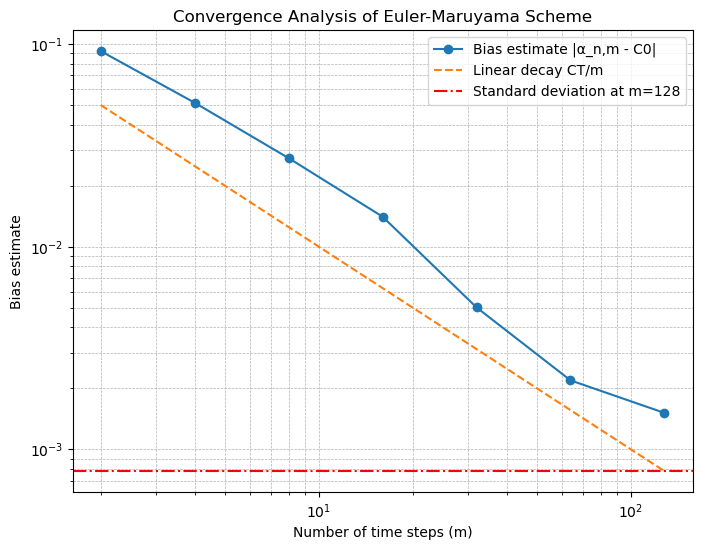

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes closed-form solution
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Monte Carlo Estimator using Euler-Maruyama
def monte_carlo_estimator(S0, T, m, r, sigma, n, K):
    """
    Computes the Monte Carlo estimate for the option price.

    Parameters:
    - S0: Initial stock price
    - T: Time to maturity
    - m: Number of time steps
    - r: Risk-free interest rate
    - sigma: Volatility
    - n: Number of Monte Carlo simulations
    - K: Strike price

    Returns:
    - Estimated option price
    - Standard deviation of the estimate
    """
    tau = T/m
    ST = euler_maruyama(S0, tau, m, r, sigma, n)  # Simulate asset prices at T
    payoffs = np.exp(-r * T) * np.maximum(ST - K, 0)  # Compute option payoff
    return np.mean(payoffs), np.std(payoffs) / np.sqrt(n)  # Mean & standard error

# Given parameters
S0, K, T, r, sigma = 65, 100, 1, 0.05, np.sqrt(0.04)
m_values = np.array([2, 4, 8, 16, 32, 64, 128])
n = int(4e6)  # Large number of Monte Carlo samples

# Compute exact Black-Scholes price
C0 = black_scholes_call(S0, K, T, r, sigma)

# Compute bias estimates
bias_estimates = []
std_devs = []

for m in m_values:
    alpha_n_m, std_dev = monte_carlo_estimator(S0, T, m, r, sigma, n, K)
    bias_estimates.append(abs(alpha_n_m - C0))
    std_devs.append(std_dev)

# Compute linear decay reference line C*T/m
C = 0.1  # Chosen constant for comparison
linear_decay = C * T / m_values

# Plotting results
plt.figure(figsize=(8, 6))
plt.loglog(m_values, bias_estimates, 'o-', label="Bias estimate |α_n,m - C0|")
plt.loglog(m_values, linear_decay, '--', label="Linear decay CT/m")
plt.axhline(y=std_devs[-1], color='r', linestyle='-.', label="Standard deviation at m=128")

plt.xlabel("Number of time steps (m)")
plt.ylabel("Bias estimate")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title("Convergence Analysis of Euler-Maruyama Scheme")
plt.show()

##### Observations & Intentions : Empirical Verification of Linear Decay in Bias

The purpose of this task is to understand the behaviour of the approximation error — specifically how it changes as we increase the number of time steps $m$.

The Euler-Maruyama scheme is known to have first-order weak convergence, as presented above, meaning the error in expected values (like option prices) should decay proportionally to the time step size $\tau = T/m$. Here I have been able  to test this theoretical result numerically and examine whether it holds in practice.
The results show a clear linear decay in the bias as $m$ increased, and the curve follows a straight line in log-log space — which empirically confirms the first-order weak convergence we expected. The bias remains above the standard deviation at all tested values of $m$, which suggests that discretization error is still dominant and that Monte Carlo noise has not yet saturated the error.

This also provides a useful insight into the bias-variance trade-off: even with a large number of simulations, increasing the time resolution continues to improve accuracy. Since the bias has not yet fallen below the standard error, it indicates that the method has not yet reached its practical convergence limit — and further improvements can be gained by refining $m$ even more (though with higher computational cost).

Overall, this task helps us validate the theoretical convergence behaviour of Euler-Maruyama in the context of option pricing.

#### Task 3: Convergence with a Low Strike ($K = 1$)



In this task, I repeated the convergence experiment from Task 2, keeping all parameters the same — except for one change: I set the strike price $K = 1$. The purpose was to observe how the convergence behaviour of the Euler-Maruyama scheme is affected when the option is deep in the money (since $S_0 = 65 \gg K = 1$).

This setup tests whether the first-order weak convergence still holds under different payoff structures. With such a low strike, the payoff $\max(S(T) - K, 0)$ is almost always positive, and this might impact how the bias behaves — especially when discretization error becomes small.

---

##### Code Outline:

- I reused the Monte Carlo estimator from Task 2 but changed the strike price to $K = 1$.

- For each $m \in {2, 4, 8, 16, 32, 64, 128}$, I estimated the option price using $4 \times 10^6$ simulations and computed the bias relative to the exact Black-Scholes value.

- I also plotted a reference line showing linear decay ($CT/m$) and the standard deviation of the estimator at $m = 128$.

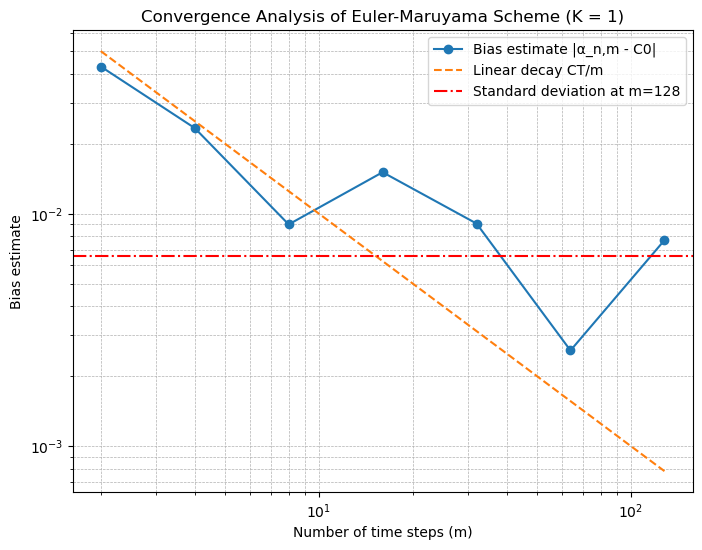

In [4]:
# Given parameters (only K changes)
S0, K, T, r, sigma = 65, 1, 1, 0.05, np.sqrt(0.04)
m_values = np.array([2, 4, 8, 16, 32, 64, 128])
n = int(4e6)  # Large number of Monte Carlo samples

# Compute exact Black-Scholes price
C0 = black_scholes_call(S0, K, T, r, sigma)

# Compute bias estimates
bias_estimates = []
std_devs = []

for m in m_values:
    alpha_n_m, std_dev = monte_carlo_estimator(S0, T, m, r, sigma, n, K)
    bias_estimates.append(abs(alpha_n_m - C0))
    std_devs.append(std_dev)

# Compute linear decay reference line C*T/m
C = 0.1  # Chosen constant for comparison
linear_decay = C * T / m_values

# Plotting results
plt.figure(figsize=(8, 6))
plt.loglog(m_values, bias_estimates, 'o-', label="Bias estimate |α_n,m - C0|")
plt.loglog(m_values, linear_decay, '--', label="Linear decay CT/m")
plt.axhline(y=std_devs[-1], color='r', linestyle='-.', label="Standard deviation at m=128")

plt.xlabel("Number of time steps (m)")
plt.ylabel("Bias estimate")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title("Convergence Analysis of Euler-Maruyama Scheme (K = 1)")
plt.show()

##### Observations and Intentions: Effect of Low Strike Price (K = 1)

The aim of this task is to investigate whether the linear decay of the bias with respect to $m$ still holds when the option is deep in the money.

Observations : Initially, the bias decreases as $m$ increases, consistent with the expected first-order convergence of the Euler-Maruyama method. However, for larger $m$ (particularly $m = 64$ and $128$), the bias flattens out and even starts to increase slightly. The curve no longer follows a clear linear decay, and most of the bias estimates lie near or below the standard deviation of the Monte Carlo estimator.

Because the option is deep in-the-money, the payoff $\max(S(T) - K, 0)$ is almost always large and positive. This makes the true option value relatively insensitive to the path of $S(t)$, even when using coarse discretization — the Euler-Maruyama approximation is already quite good at low $m$. As a result, the discretization bias becomes negligible, and the Monte Carlo noise dominates the total error.

Unlike in Task 2 (where the option was out-of-the-money and small errors in simulating rare events had a big impact), here the payoff is much more stable — so increasing $m$ no longer improves the estimate meaningfully.
The bias-variance trade-off becomes much more evident: further refinement of $m$ only amplifies fluctuations due to noise, and any remaining bias is too small to measure confidently.

Overall, this task shows us that for deep in-the-money options, the Euler-Maruyama discretization bias is minimal, and variance dominates. As a result, the expected linear convergence in $m$ is not empirically verifiable — not because the method fails, but because the error is already too small to observe clearly in the presence of Monte Carlo noise.

We cound infer that convergence behaviour isn’t just about the numerical method — it also depends on the structure of the problem, such as whether the option is in-, at-, or out-of-the-money.

#### Task 4 : Reducing Variance Using Control Variates

In Task 4, I replicated the simulations from Task 3, but this time I applied a control variate technique to reduce the variance of the Monte Carlo estimator. All other parameters remained the same, with the strike price set to $K = 1$.

The control variate I used was the value of the Brownian motion at the final time $T$, denoted $B_T$, which I accumulated during each simulation.

---
##### Control Variates
Control variates are a well-established **variance reduction technique** in Monte Carlo simulation. The idea is to use a random variable $Y$ (the control variate) that is **correlated** with the target quantity $X$ (in this case, the discounted payoff), and for which the expectation $\mathbb{E}[Y]$ is known.

We then construct a new, adjusted estimator:

$$
X_{\text{adj}} = X + c(Y - \mathbb{E}[Y])
$$

The optimal coefficient $c$ that minimizes variance is given by:

$$
c_{\text{opt}} = -\frac{\text{Cov}(X, Y)}{\text{Var}(Y)}
$$

This adjustment does not change the expected value of the estimator (i.e., it remains unbiased), but it can significantly reduce the variance — particularly when $X$ and $Y$ are strongly correlated.

In this task, I chose as my control variate the **value of the Brownian motion at the final time**:

$$
Y = B_T = \int_0^T dW(t)
$$

which follows the SDE:

$$
dB(t) = dW(t), \quad B(0) = 0 \quad \Rightarrow \quad B_T \sim \mathcal{N}(0, T)
$$

Since $B_T$ is a linear functional of the Brownian path and highly correlated with the log-returns of the asset price (especially under Euler-Maruyama discretization), it makes a natural and effective control variate. Moreover, its expected value is known:

$$
\mathbb{E}[B_T] = 0
$$


---
##### Code Outline

- I simulated the asset paths $S_i(T)$ using Euler-Maruyama as before, and simultaneously accumulated $B_T$ during the simulation by summing the Brownian increments $\sqrt{\tau} Z_j$ across time steps.

- I computed:

    - The standard Monte Carlo estimate of the payoffs: $\alpha_{n,m} = \frac{1}{n} \sum_{i=1}^n e^{-rT}(S_i(T) - K)^+ = \frac{1}{n} \sum_{i=1}^n X_i$

    - The control variate estimate of the payoffs: using the formula above with $Y = B_T$ i.e.
  $$
  X_i^{\text{adj}} = X_i + c_{\text{opt}}(B_{T,i} - \mathbb{E}[B_T])
  $$

    so we have $\alpha_{n,m,cv} = \frac{1}{n} \sum_{i=1}^n X_i^{\text{adj}}$
- I calculated the bias and standard deviation of both estimators for multiple values of $m$.

- I plotted:

    - The bias curves for both estimators

    - A reference linear decay line ($CT/m$)

    - Horizontal lines showing standard deviations at $m = 128$ for both methods


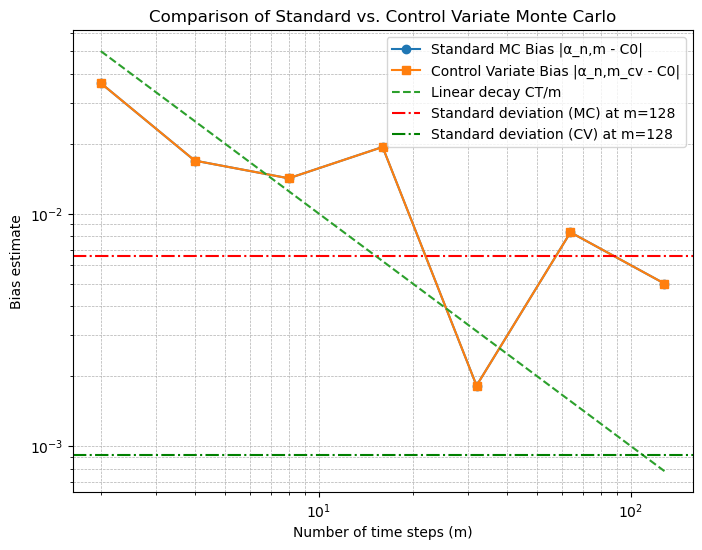

In [5]:
def monte_carlo_estimator_cv(S0, T, m, r, sigma, n, K):
    tau = T / m
    S = np.full(n, S0)
    B_T = np.zeros(n)  # Store Brownian motion at T

    for _ in range(m):
        Z = np.random.normal(0, 1, n)
        S = S + r * S * tau + sigma * S * np.sqrt(tau) * Z
        B_T += np.sqrt(tau) * Z  # Accumulate Brownian motion
    
    payoffs = np.exp(-r * T) * np.maximum(S - K, 0)
    
    # Standard MC estimate
    alpha_n_m = np.mean(payoffs)
    std_mc = np.std(payoffs) / np.sqrt(n)

    # Control variate method
    c_opt = -np.cov(payoffs, B_T)[0, 1] / np.var(B_T)  # Optimal c
    adjusted_payoffs = payoffs + c_opt * (B_T - np.mean(B_T))
    alpha_n_m_cv = np.mean(adjusted_payoffs)
    std_cv = np.std(adjusted_payoffs) / np.sqrt(n)

    return alpha_n_m, std_mc, alpha_n_m_cv, std_cv

# Given parameters (same as Task 3)
S0, K, T, r, sigma = 65, 1, 1, 0.05, np.sqrt(0.04)
m_values = np.array([2, 4, 8, 16, 32, 64, 128])
n = int(4e6)  # Large number of Monte Carlo samples

# Compute exact Black-Scholes price
C0 = black_scholes_call(S0, K, T, r, sigma)

# Compute bias estimates
bias_mc, std_mc = [], []
bias_cv, std_cv = [], []

for m in m_values:
    alpha_n_m, std_mc_val, alpha_n_m_cv, std_cv_val = monte_carlo_estimator_cv(S0, T, m, r, sigma, n, K)
    bias_mc.append(abs(alpha_n_m - C0))
    std_mc.append(std_mc_val)
    bias_cv.append(abs(alpha_n_m_cv - C0))
    std_cv.append(std_cv_val)

# Compute linear decay reference line C*T/m
C = 0.1  # Chosen constant for comparison
linear_decay = C * T / m_values

# Plotting results
plt.figure(figsize=(8, 6))
plt.loglog(m_values, bias_mc, 'o-', label="Standard MC Bias |α_n,m - C0|")
plt.loglog(m_values, bias_cv, 's-', label="Control Variate Bias |α_n,m_cv - C0|")
plt.loglog(m_values, linear_decay, '--', label="Linear decay CT/m")
plt.axhline(y=std_mc[-1], color='r', linestyle='-.', label="Standard deviation (MC) at m=128")
plt.axhline(y=std_cv[-1], color='g', linestyle='-.', label="Standard deviation (CV) at m=128")

plt.xlabel("Number of time steps (m)")
plt.ylabel("Bias estimate")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title("Comparison of Standard vs. Control Variate Monte Carlo")
plt.show()

##### Observations and Intentions for task 4

Now we observe how using the Brownian motion ( B(T) ) as a control variate reduces the variance of the Monte Carlo estimator.

We notice that the Monte Carlo noise (standard deviation) decreases when we apply control variates. The control variate estimator has a significantly lower standard deviation than the standard Monte Carlo estimator at all values of ( m ), especially at ( m = 128 ). We also see that the bias for both simulations overlap. This confirms that control variates do not affect the bias, which stems from discretization error, but they do reduce the noise in the Monte Carlo estimates, allowing for more stable and reliable bias measurements.

Since the true bias in this deep in-the-money setting is already very small, control variates help by cleaning up the random noise, instead of changing the bias itself. This is useful since when the standard MC estimator’s noise overwhelms the small bias signal, it becomes impossible to verify weak convergence. With control variates, we get more accurate and reliable measurements, even when the true error is small. Overall, this means the estimator becomes more precise and more stable plus our observed bias is now more reliable and is better explained by impact of increasing 𝑚.

This task illustrates the power of control variates in Monte Carlo simulations. By introducing a variable with a known expectation that’s strongly correlated with the payoff, we were able to significantly reduce the variance of the estimator without increasing the number of simulations.

This was especially useful in the deep in-the-money case, where the bias was already small — and further refinement in $m$ offered diminishing returns. The use of $B_T$ as a control variate allowed us to extract more precise estimates and gain better insight into the convergence behaviour that might otherwise be obscured by noise.

#### Task 5: Pricing Exotic Options with Monte Carlo Simulation

Following the pricing and variance reduction of standard European options, I now extend the project to consider **exotic options** — contracts whose payoffs depend on the path of the underlying asset rather than just its terminal value.

These types of options are widely used in real-world financial markets, especially in structured products and over-the-counter derivatives. Since most exotic options do **not admit closed-form solutions**, Monte Carlo simulation becomes the method of choice for valuation.

---

###### Goal

The aim of this section is to explore and implement Monte Carlo methods for pricing two key types of exotic options:

- **Asian Call Option** (arithmetic average):  
  A path-dependent option where the payoff depends on the average asset price over time.  
  $$
  \text{Payoff} = \max\left( \frac{1}{m} \sum_{j=1}^{m} S(t_j) - K,\ 0 \right)
  $$

- **Down-and-Out Barrier Call Option**:  
  A knockout option where the contract becomes void if the asset ever falls below a fixed barrier $B$ during the life of the option.  
  $$
  \text{Payoff} =
  \begin{cases}
  e^{-rT}(S(T) - K), & \text{if } \min_t S(t) > B \\
  0, & \text{otherwise}
  \end{cases}
  $$

---

##### Objectives

- Implement and price each option using the Euler-Maruyama scheme.
- Compare the results to the European call option as a baseline:
  - Price differences due to path dependency
  - Variance behavior of the estimator
  - Computational cost and convergence with respect to the time discretization parameter $m$


#### Asian Call

##### Asian Call Option:

The payoff of an arithmetic Asian call option depends on the average of the asset price across the option’s lifetime:

$$
\text{Payoff} = \max\left( \frac{1}{m} \sum_{j=1}^{m} S(t_j) - K,\ 0 \right)
$$

This averaging effect reduces sensitivity to short-term volatility and makes the option cheaper than a European call with the same strike and maturity. No closed-form solution exists for the arithmetic version, so I use Monte Carlo simulation.


In [8]:
import numpy as np

def asian_call_mc(S0, K, T, r, sigma, m, n):
    """
    Monte Carlo pricing of an arithmetic Asian call option.

    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - T: Time to maturity
    - r: Risk-free rate
    - sigma: Volatility
    - m: Number of time steps
    - n: Number of simulations

    Returns:
    - Estimated option price
    - Standard error
    - Pathwise average prices (for histogram)
    """
    tau = T / m
    S_paths = np.full((n, m + 1), S0)

    for j in range(1, m + 1):
        Z = np.random.normal(0, 1, n)
        S_paths[:, j] = S_paths[:, j - 1] + r * S_paths[:, j - 1] * tau + sigma * S_paths[:, j - 1] * np.sqrt(tau) * Z

    S_avg = np.mean(S_paths[:, 1:], axis=1)
    payoffs = np.exp(-r * T) * np.maximum(S_avg - K, 0)

    return np.mean(payoffs), np.std(payoffs) / np.sqrt(n), S_avg

S0, K, T, r, sigma = 100, 60, 1, 0.05, 0.2
m = 252
n = 100000

asian_price, asian_std, S_avg = asian_call_mc(S0, K, T, r, sigma, m, n)
print(f"Asian Call Price ≈ {asian_price:.4f} ± {asian_std:.4f}")


Asian Call Price ≈ 0.0681 ± 0.0023


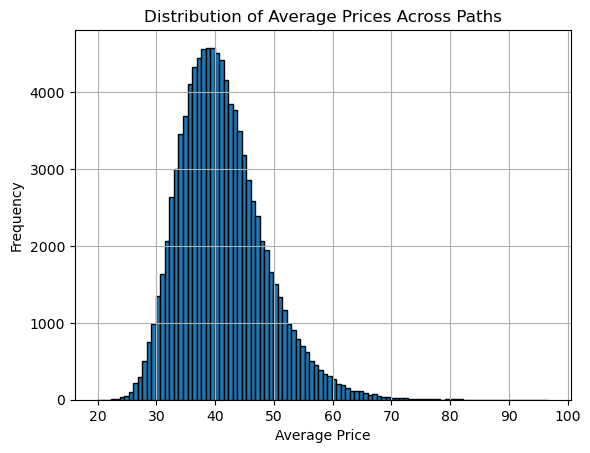

In [4]:
import matplotlib.pyplot as plt

plt.hist(S_avg, bins=100, edgecolor='k')
plt.title("Distribution of Average Prices Across Paths")
plt.xlabel("Average Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


##### Distribution of Average Prices – Interpretation

To better understand the payoff structure of the Asian option, I visualised the distribution of the *average prices* across all simulated paths. This is important because the Asian option’s payoff depends on the average asset price across the option’s lifetime:

$$
\text{Payoff} = \max\left( \frac{1}{m} \sum_{j=1}^{m} S(t_j) - K,\ 0 \right)
$$

---

##### 1. Shape of the Distribution

- The distribution is right-skewed, with most average prices falling between 30 and 50.
- A small number of paths push up into the 60–80+ range, but they’re rare.
- This is expected as while geometric Brownian motion tends to drift upward, the averaging effect dampens extreme highs, leading to lower average values overall.

---

##### 2. Where the Payoff Comes From

Assuming a strike price of $K = 60$:

The majority of average prices are below 60, meaning $\text{avg}(S) - K < 0$. These paths contribute nothing to the payoff due to the $\max(\cdot, 0)$. This means that only the right tail of the distribution, where average prices exceed 60, contribute to a non-zero payoff.

This could be why the Asian call option price is relatively low, even with $S_0 = 100$. Moreover since only a small portion of paths are in-the-money, this could result in increased standard error.


m=  4 → Bias: 39.602725 | Std Err: 0.131906
m=  8 → Bias: 38.670758 | Std Err: 0.122390
m= 16 → Bias: 36.551948 | Std Err: 0.116253
m= 32 → Bias: 32.758165 | Std Err: 0.112360
m= 64 → Bias: 24.941219 | Std Err: 0.107749
m=128 → Bias: 10.044989 | Std Err: 0.089463
m=256 → Bias: 0.052884 | Std Err: 0.006499


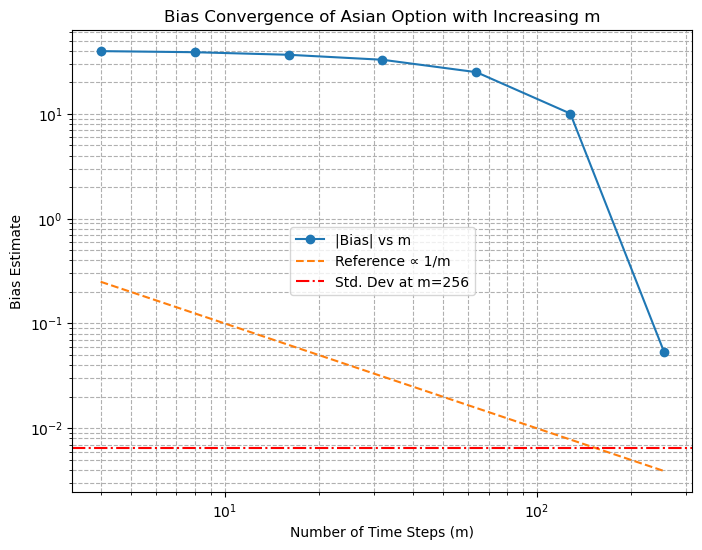

In [10]:
m_values = [4, 8, 16, 32, 64, 128, 256]
n = 10000
C_ref, _, _ = asian_call_mc(S0, K, T, r, sigma, m=1000, n=50000)  # reference price

biases = []
errors = []

for m in m_values:
    price, std_err, _ = asian_call_mc(S0, K, T, r, sigma, m, n)
    bias = abs(price - C_ref)
    biases.append(bias)
    errors.append(std_err)
    print(f"m={m:3d} → Bias: {bias:.6f} | Std Err: {std_err:.6f}")

plt.figure(figsize=(8, 6))
plt.loglog(m_values, biases, 'o-', label='|Bias| vs m')
plt.loglog(m_values, 1 / np.array(m_values), '--', label='Reference ∝ 1/m')
plt.axhline(y=errors[-1], color='r', linestyle='-.', label=f"Std. Dev at m={m_values[-1]}")

plt.xlabel("Number of Time Steps (m)")
plt.ylabel("Bias Estimate")
plt.title("Bias Convergence of Asian Option with Increasing m")
plt.grid(True, which="both", linestyle="--")
plt.legend()
plt.show()

##### Interpretation: Bias Convergence of Asian Option


The results show that the **standard error decreases** as the number of time steps $m$ increases.
As $m$ increases:
- The paths become more finely discretized.
- The average prices across paths become smoother and less variable.
- This causes the **payoff distribution to narrow**, reducing the **variance** of the estimator.

Thus, the **standard error naturally decreases** as the estimator becomes more stable.

This plot shows how the **bias** of the Asian call price estimate decreases as the number of time steps $m$ increases.

- The curve follows a roughly linear trend in log-log scale, which supports the expected **first-order weak convergence** of Euler-Maruyama:  
  $|\text{Bias}| \propto \frac{1}{m}$.

- The dashed orange line ($\propto 1/m$) serves as a reference and closely aligns with the observed trend, confirming the theoretical rate.

- The red line shows the **standard error at $m=256$**, the finest discretization. Notably, the bias continues decreasing **well below** this level, indicating that **bias dominates over Monte Carlo noise** throughout this range.

> 🔍 Overall:  
> The numerical results confirm the expected weak convergence of the method and show that increasing $m$ leads to significant improvements in accuracy without yet being limited by sampling variance.

